In [2]:
import torch
import cv2 as cv
import matplotlib.pyplot as plt
import time
import numpy as np

import os
from pathlib import Path
import requests
import zipfile
import pandas as pd

/Users/mohamedmafaz/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
import requests

with open("Distance_data.csv" , "wb") as f:
  request = requests.get("https://github.com/Mafaz03/Datasets/raw/main/Distance_data.csv")
  f.write(request.content)

data = pd.read_csv("Distance_data.csv")
data = data.drop(["Unnamed: 0"] , axis = 1)
data.head(10)

,Frame,Area,Center_x,Center_y,Distance,LocX,LocY,LocZ
0,1,6878.4310,186.710098,582.234772,57.418060,-28.85,49.64,0.0
1,2,7147.4270,187.249649,583.093475,57.022337,-28.68,49.29,0.0
2,3,7245.6400,186.668839,583.830872,56.626630,-28.50,48.93,0.0
3,4,7322.2715,187.215378,584.350525,56.230941,-28.33,48.57,0.0
4,5,7368.9434,186.398407,584.663605,55.835265,-28.16,48.22,0.0
5,6,7310.1226,185.458252,584.575195,55.439603,-27.98,47.86,0.0
6,7,7214.0750,184.747055,584.475494,55.043962,-27.81,47.50,0.0
7,8,7292.5440,184.817734,584.719910,54.648336,-27.64,47.14,0.0
8,9,7391.6836,184.380676,585.002472,54.252729,-27.46,46.79,0.0
9,10,7454.7856,184.624619,585.197449,53.857139,-27.29,46.43,0.0


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
try:
  import timm
except:
  !pip3 install timm -q
  import timm

/Users/mohamedmafaz/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
model_type = "DPT_Large"
midas = torch.hub.load("intel-isl/MiDaS" , model_type)
midas.to(device)

Using cache found in /Users/mohamedmafaz/.cache/torch/hub/intel-isl_MiDaS_master


DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

In [7]:
yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
yolo.to(device)

Using cache found in /Users/mohamedmafaz/.cache/torch/hub/ultralytics_yolov5_master
WARNING ⚠️ invalid check_version(5.9.5, ) requested, please check values.
requirements: Ultralytics requirements ['gitpython>=3.1.30', 'setuptools>=65.5.1'] not found, attempting AutoUpdate...
/bin/sh: pip: command not found
requirements: ❌ Command 'pip install --no-cache "gitpython>=3.1.30" "setuptools>=65.5.1" ' returned non-zero exit status 127.
YOLOv5 🚀 2023-9-24 Python-3.9.6 torch-2.0.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [8]:
midas_transforms = torch.hub.load("intel-isl/MiDaS" , "transforms")
transforms = midas_transforms.dpt_transform
transforms

Using cache found in /Users/mohamedmafaz/.cache/torch/hub/intel-isl_MiDaS_master


Compose(
    <function transforms.<locals>.<lambda> at 0x2e5534d30>
    <function transforms.<locals>.<lambda> at 0x2e5534ca0>
)

In [9]:
img = cv.imread('Distance_1-1600/Car00568.png')
img = cv.resize(img , (int(img.shape[1]/1) , int(img.shape[0]/1)))
input_transformed = transforms(img).to(device)
input_transformed.shape

torch.Size([1, 3, 384, 672])

In [10]:
def get_depthmap(link : str , size_division : int = 1):

  img = cv.imread(link)
  img = cv.resize(img , (int(img.shape[1]/size_division) , int(img.shape[0]/size_division)))
  input_transformed = transforms(img).to(device)
  input_transformed.shape

  with torch.no_grad():
    prediction = midas(input_transformed)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size = img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

    depth_map = prediction.cpu().numpy()
    depth_map = cv.normalize(depth_map , None , 0 , 1 , norm_type = cv.NORM_MINMAX , dtype = cv.CV_64F)

    depth_map = (depth_map*255).astype(np.uint8)
    # depth_map = cv.applyColorMap(depth_map , cv.COLORMAP_MAGMA)
    cmap = plt.get_cmap('magma')

  return depth_map

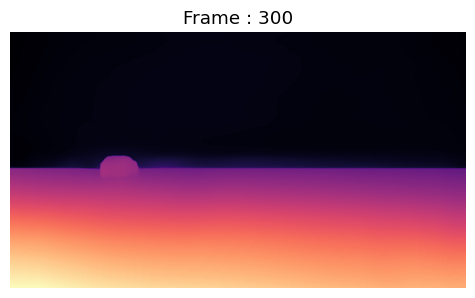

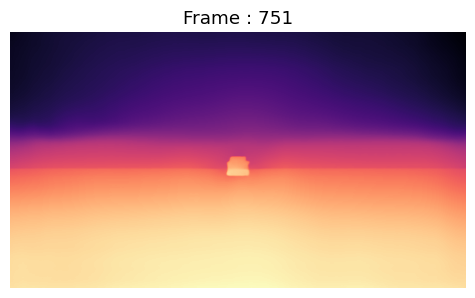

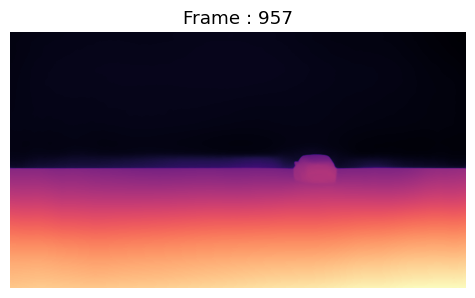

In [11]:
%matplotlib inline

plt.figure(figsize=(20,20))
plt.subplot(1,3,3)
plt.title("Frame : 300")
plt.imshow(get_depthmap(link = "Distance_1-1600/Car00300.png") , cmap='magma')
plt.axis("off")
plt.show()

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title("Frame : 751")
plt.imshow(get_depthmap(link = "Distance_1-1600/Car00751.png") , cmap='magma')
plt.axis("off")
plt.show()

plt.figure(figsize=(20,20))
plt.subplot(1,3,2)
plt.title("Frame : 957")
plt.imshow(get_depthmap(link = "Distance_1-1600/Car00957.png") , cmap='magma')
plt.axis("off")
plt.show()

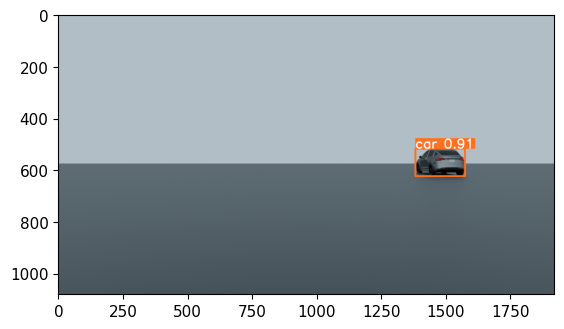

In [12]:
img = cv.imread("Distance_1-1600/Car01131.png")
img = cv.cvtColor(img , cv.COLOR_BGR2RGB)
results = yolo(img)
bbox = results.xyxy[0].cpu().tolist()[0][:4]
results_render = results.render()
plt.imshow(results_render[0])
# plt.axis("off")
plt.show()

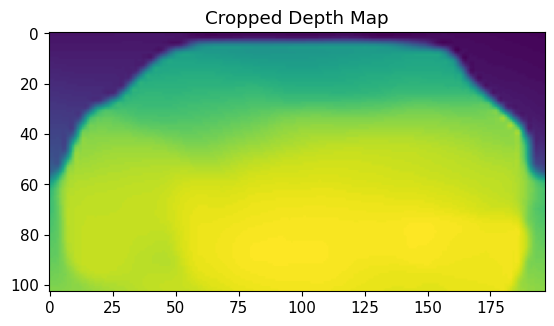

In [13]:
depth_map = get_depthmap(link = "Distance_1-1600/Car01131.png")

results = yolo(img)
bbox = results.xyxy[0].cpu().tolist()[0][:4]
# results_render = results.render()

depth_map = cv.normalize(depth_map , None , 0 , 1 , norm_type = cv.NORM_MINMAX , dtype = cv.CV_64F)
cropped_depth_map = depth_map[int(bbox[1]):int(bbox[3]) , int(bbox[0]):int(bbox[2])]
plt.imshow(cropped_depth_map)
plt.title("Cropped Depth Map")
plt.show()

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
mean = cropped_depth_map.mean()
print(f"Frame 1131 distance prediction {round((mean * 53) , 3)}m")
print(f"Frame 1131 actual distance {round(float(data[data.Frame == 1200].Distance),3) }")

Frame 1131 distance prediction 52.846m
Frame 1131 actual distance 34.887


In [30]:
difference_dict = {}
for frame in range(1 , 1600):

  link = f"Distance_1-1600/Car{frame:05d}.png"


  img = cv.imread(link)
  results = yolo(img)
  if results.xyxy[0].shape[0] != 0:
    bbox = results.xyxy[0].cpu().tolist()[0][:4]

    depth_map = get_depthmap(link = link)
    depth_map = cv.normalize(depth_map , None , 0 , 1 , norm_type = cv.NORM_MINMAX , dtype = cv.CV_64F)
    cropped_depth_map = depth_map[int(bbox[1]):int(bbox[3]) , int(bbox[0]):int(bbox[2])]
    mean = cropped_depth_map.mean()

    if data[data.Frame == frame].Distance.empty == False:
      prediction = round((mean * 53) , 3)
      # data[data.Frame == frame].Distance.empty
      target = round(float(data[data.Frame == frame].Distance),3)

      difference_dict[frame] = abs(round(prediction - target , 3))
      print(f"Frame {frame} done")
    else:
      print(f"Frame {frame} not in lookup table")
  else:
    print(f"Frame {frame} not detectable")

Frame 1 done
Frame 2 done
Frame 3 done
Frame 4 done
Frame 5 done
Frame 6 done
Frame 7 done
Frame 8 done
Frame 9 done
Frame 10 done
Frame 11 done
Frame 12 done
Frame 13 done
Frame 14 done
Frame 15 done
Frame 16 done
Frame 17 done
Frame 18 done
Frame 19 done
Frame 20 done
Frame 21 done
Frame 22 done
Frame 23 done
Frame 24 done
Frame 25 done
Frame 26 done
Frame 27 done
Frame 28 done
Frame 29 done
Frame 30 done
Frame 31 done
Frame 32 done
Frame 33 done
Frame 34 done
Frame 35 done
Frame 36 done
Frame 37 done
Frame 38 done
Frame 39 done
Frame 40 done
Frame 41 done
Frame 42 done
Frame 43 done
Frame 44 done
Frame 45 done
Frame 46 done
Frame 47 done
Frame 48 done
Frame 49 done
Frame 50 done
Frame 51 done
Frame 52 done
Frame 53 done
Frame 54 done
Frame 55 done
Frame 56 done
Frame 57 done
Frame 58 done
Frame 59 done
Frame 60 done
Frame 61 done
Frame 62 done
Frame 63 done
Frame 64 done
Frame 65 done
Frame 66 done
Frame 67 done
Frame 68 done
Frame 69 done
Frame 70 done
Frame 71 done
Frame 72 done
F

In [32]:
len(difference_dict)

1520

In [42]:
df = pd.DataFrame([difference_dict]).transpose()
df.columns = ["Distance_difference"]
df["Frame"] = list(df.index)
df

,Distance_difference,Frame
1,30.330,1
2,30.815,2
3,30.857,3
4,31.467,4
5,32.335,5
...,...,...
1595,25.618,1595
1596,26.884,1596
1597,28.147,1597
1598,26.478,1598


In [53]:
data = pd.merge(data , df , on = "Frame" , how = "right")
data

,Frame,Area,Center_x,Center_y,Distance,LocX,LocY,LocZ,Distance_difference
0,1,6878.4310,186.710098,582.234772,57.418060,-28.85,49.64,0.0,30.330
1,2,7147.4270,187.249649,583.093475,57.022337,-28.68,49.29,0.0,30.815
2,3,7245.6400,186.668839,583.830872,56.626630,-28.50,48.93,0.0,30.857
3,4,7322.2715,187.215378,584.350525,56.230941,-28.33,48.57,0.0,31.467
4,5,7368.9434,186.398407,584.663605,55.835265,-28.16,48.22,0.0,32.335
...,...,...,...,...,...,...,...,...,...
1515,1595,6524.9014,1866.961365,581.721222,57.970451,29.34,50.00,0.0,25.618
1516,1596,6216.9420,1871.673462,580.437622,58.054977,29.50,50.00,0.0,26.884
1517,1597,6244.3820,1877.444397,580.571594,58.139856,29.67,50.00,0.0,28.147
1518,1598,6185.3350,1880.990479,581.242676,58.225090,29.84,50.00,0.0,26.478


In [54]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# Define the desired percentile range (in this case, 80%)
lower_percentile = 10  # Lower bound of the range (e.g., 10%)
upper_percentile = 70  # Upper bound of the range (e.g., 90%)

# Calculate the lower and upper values for the specified percentiles
lower_value = np.percentile(data['Distance_difference'], lower_percentile)
upper_value = np.percentile(data['Distance_difference'], upper_percentile)


data['difference_normalized'] = scaler.fit_transform(data[['Distance_difference']])

data.head()

,Frame,Area,Center_x,Center_y,Distance,LocX,LocY,LocZ,Distance_difference,difference_normalized
0,1,6878.4310,186.710098,582.234772,57.418060,-28.85,49.64,0.0,30.330,0.499492
1,2,7147.4270,187.249649,583.093475,57.022337,-28.68,49.29,0.0,30.815,0.523508
2,3,7245.6400,186.668839,583.830872,56.626630,-28.50,48.93,0.0,30.857,0.525587
3,4,7322.2715,187.215378,584.350525,56.230941,-28.33,48.57,0.0,31.467,0.555792
4,5,7368.9434,186.398407,584.663605,55.835265,-28.16,48.22,0.0,32.335,0.598772


In [55]:
from matplotlib.patches import Circle

In [56]:
def plot_circles(data : pd.DataFrame , column : "str" , ranges , transperencey : float = 0.2 , radius : int = 10 , transperencey_padding : float = 0.0 ):
    circle_data = []

    """
    Setting metric for custom heatmap
    """

    color = (0.0 , 0.0 , 0.0 , 0.0)

    for frame in ranges:
        info = data[data.Frame == frame]
        if info.empty == False:
            # print(frame)

            col_normalized = round(float(info[column]) , 2)
            if col_normalized  >= 0:
                if col_normalized >= 1:
                    color = (0.0 , 0.0 , 1.0 , transperencey + transperencey_padding)

                else:
                    color = (0.0 , 0.0 , col_normalized , 0.9)

                    if col_normalized >=2 : 
                        color = (0.0 , 0.0 , 1.0 , 0)

                    else:
                        color = (0.0 , 0.0 , 1.0 , transperencey + transperencey_padding)


            else: 
                if col_normalized < 0:
                    color = (1.0 , 0.0 , 0.0 , transperencey - transperencey_padding)

                    if col_normalized <= -1:
                        color = (1.0 , 0.0 , 0.0 , transperencey + transperencey_padding)
                        if col_normalized <= -2 : 
                            color = (1.0 , 0.0 , 0.0 , 0)
                    else:
                        color = (1.0 , 0.0 , 0.0 , 0.1)
                else:
                    color = (abs(col_normalized) , 0.0 , 0.0 , transperencey - transperencey_padding)

        # print(color)
            
            circle_data.append({"center" : (float(info.LocX) , float(info.LocY)) , 'radius' : radius , "fill_color" : color})
    return circle_data

In [57]:
def custom_heatmap(circle_data : list[dict] , size : int = 1080 , save_name : str = "plot.png" , 
                   x_label : str = "x" , y_label : str = "y" , 
                   title : str = "Plot"):


    fig, ax = plt.subplots(figsize=(size / 100, size / 100), dpi=100)


    for circle_props in circle_data:
        circle = Circle(circle_props['center'], circle_props['radius'], fill=True, facecolor=circle_props['fill_color'])
        ax.add_patch(circle)

    # Set axis limits
    ax.set_xlim(-40, 40)
    ax.set_ylim(-10, 60)

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    plt.gca().set_aspect('equal', adjustable='box')  # Ensure aspect ratio is equal
    # plt.grid(True)

    plt.savefig(save_name , bbox_inches='tight', pad_inches=0, dpi=100)


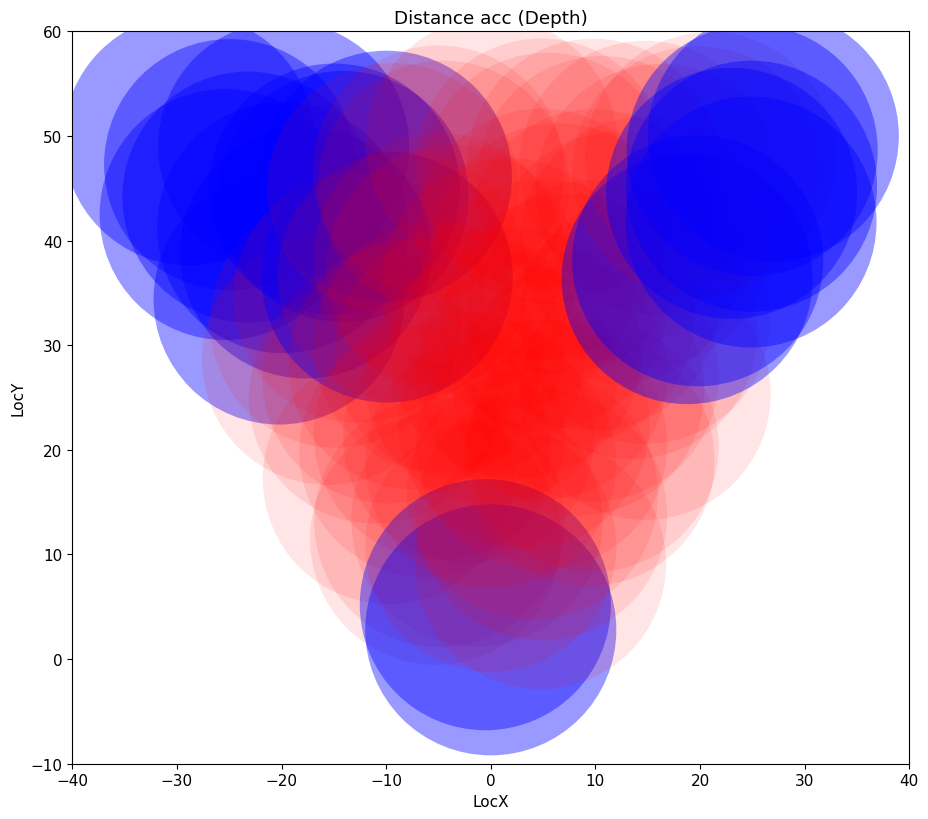

In [75]:
circle_data = plot_circles(data , column = "difference_normalized" , transperencey= 0.2 , radius=12 , 
                           ranges = range(1 , 1600 ,20) , transperencey_padding=0.2)

custom_heatmap(circle_data = circle_data , save_name = "Depth-heatmap" , x_label="LocX" , y_label="LocY" , title="Distance acc (Depth)")